# A Simple GAN with Keras

## Import modules and set relevant parameters

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
# from tqdm import tqdm

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
from keras.models import model_from_json

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Use Tensorflow for Keras backend
os.environ["KERAS_BACKEND"] = "tensorflow"

# Make sure we can reproduce the experiment and get the same result
np.random.seed(10)

# The dimension of our random noise vector
random_dim = 100

## Gathering and preprocessing MNIST data

Keras includes MNIST as an example dataset

In [3]:
def load_mnist_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    # remember that the value of each attribute (pixel) ranges from 0 to 255
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

## Defining our optimizer
We will use the stochastic gradient-based optimizer Adam

In [4]:
# Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

## Defining our generator and discriminator

Each function will be represented by a Neural Network with three hidden layers. The generator will have fully connected layers (Dense) whereas the discriminator will use layers with a dropout rate of 0.3.

In [5]:
# generator
def get_generator(optimizer):
    generator = Sequential()
    
    # first hidden layer
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
    
    # second hidden layer
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
    
    # third hidden layer
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
    
    # the output layer (784 units) has a different activation function
    generator.add(Dense(784, activation='tanh'))
    
    # a Keras model needs two arguments to compile: loss function and optimizer
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return generator

# discriminator
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

# the number of units in the layers of the generator and discriminator
# are symmetrical

## Defining the GAN

Finally, we merge the functions defined above in the get_gan_network function.

In [6]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

The following function will help visualize some images generated by the GAN in each epoch.

In [7]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    fig = plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    display(fig)
    plt.savefig('gan_generated_image_epoch_{0}.png'.format(epoch))
    plt.close()

## Training function

Train_on_batch runs a single gradient update for a batch of certain batch_size. Essentially, it runs the optimization algorithm (Adam, in this case) in a mini-batch manner.

In [10]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_mnist_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch', e, '-'*15)
        for _ in range(batch_count):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            # First half of the images are real, second half are fake
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing - why??
            y_dis[:batch_size] = 0.9

            # Train discriminator on batch
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator on batch
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            # The output is defined as 'real' (y = 1)
            # We want to minimize the difference between the discriminator predictions
            # on the generated images and the probability of them being real.
            # That is, we want to train the GAN so that the generated images
            # are more likely to be classified as real by the discriminator
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)
    
    # save model
    generator_json = generator.to_json()
    with open("generator.json", "w") as json_file:
        json_file.write(generator_json)
    
    discriminator_json = discriminator.to_json()
    with open("discriminator.json", "w") as json_file:
        json_file.write(discriminator_json)
    
    gan_json = gan.to_json()
    with open("gan.json", "w") as json_file:
        json_file.write(gan_json)
    
    # save weights
    discriminator.save_weights("discriminator.h5")
    generator.save_weights("generator.h5")
    gan.save_weights("gan.h5")
    
    print("Saved model to disk")

--------------- Epoch 1 ---------------


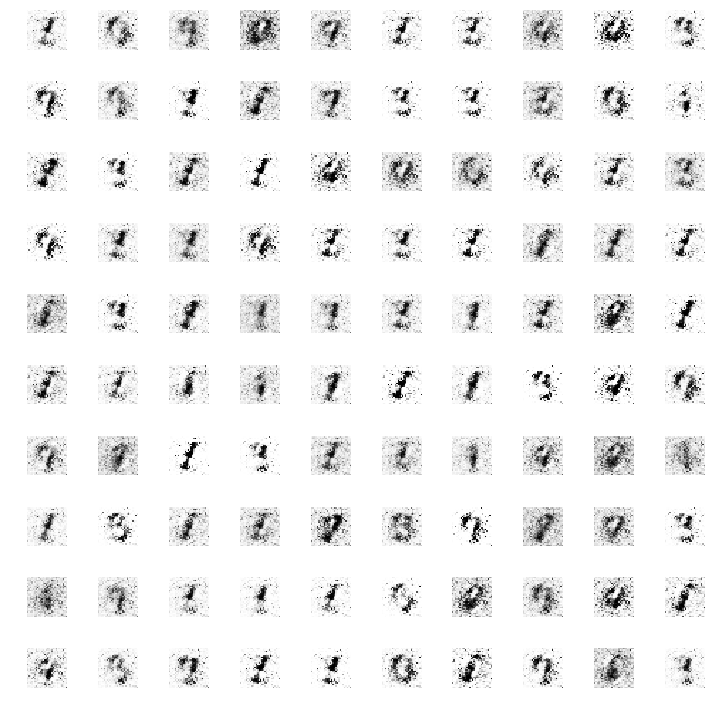

--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------
--------------- Epoch 10 ---------------
--------------- Epoch 11 ---------------
--------------- Epoch 12 ---------------
--------------- Epoch 13 ---------------
--------------- Epoch 14 ---------------
--------------- Epoch 15 ---------------
--------------- Epoch 16 ---------------
--------------- Epoch 17 ---------------
--------------- Epoch 18 ---------------
--------------- Epoch 19 ---------------
--------------- Epoch 20 ---------------


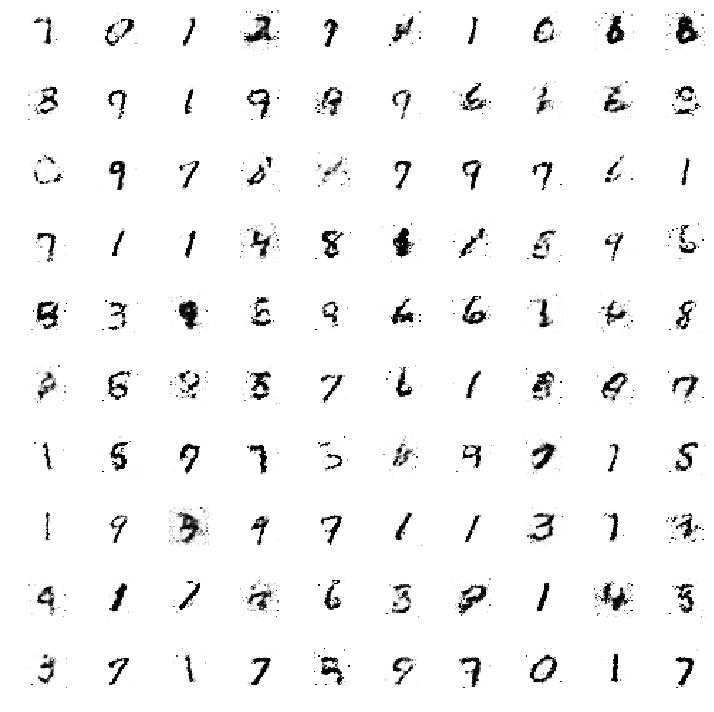

--------------- Epoch 21 ---------------
--------------- Epoch 22 ---------------
--------------- Epoch 23 ---------------
--------------- Epoch 24 ---------------
--------------- Epoch 25 ---------------
--------------- Epoch 26 ---------------
--------------- Epoch 27 ---------------
--------------- Epoch 28 ---------------
--------------- Epoch 29 ---------------
--------------- Epoch 30 ---------------
--------------- Epoch 31 ---------------
--------------- Epoch 32 ---------------
--------------- Epoch 33 ---------------
--------------- Epoch 34 ---------------
--------------- Epoch 35 ---------------
--------------- Epoch 36 ---------------
--------------- Epoch 37 ---------------
--------------- Epoch 38 ---------------
--------------- Epoch 39 ---------------
--------------- Epoch 40 ---------------


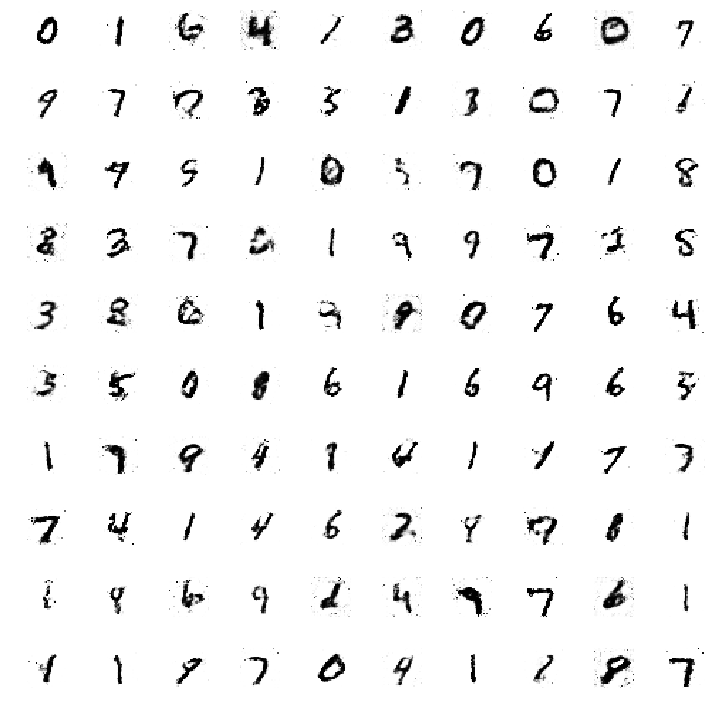

--------------- Epoch 41 ---------------
--------------- Epoch 42 ---------------
--------------- Epoch 43 ---------------
--------------- Epoch 44 ---------------
--------------- Epoch 45 ---------------
--------------- Epoch 46 ---------------
--------------- Epoch 47 ---------------
--------------- Epoch 48 ---------------
--------------- Epoch 49 ---------------
--------------- Epoch 50 ---------------
--------------- Epoch 51 ---------------
--------------- Epoch 52 ---------------
--------------- Epoch 53 ---------------
--------------- Epoch 54 ---------------
--------------- Epoch 55 ---------------
--------------- Epoch 56 ---------------
--------------- Epoch 57 ---------------
--------------- Epoch 58 ---------------
--------------- Epoch 59 ---------------
--------------- Epoch 60 ---------------


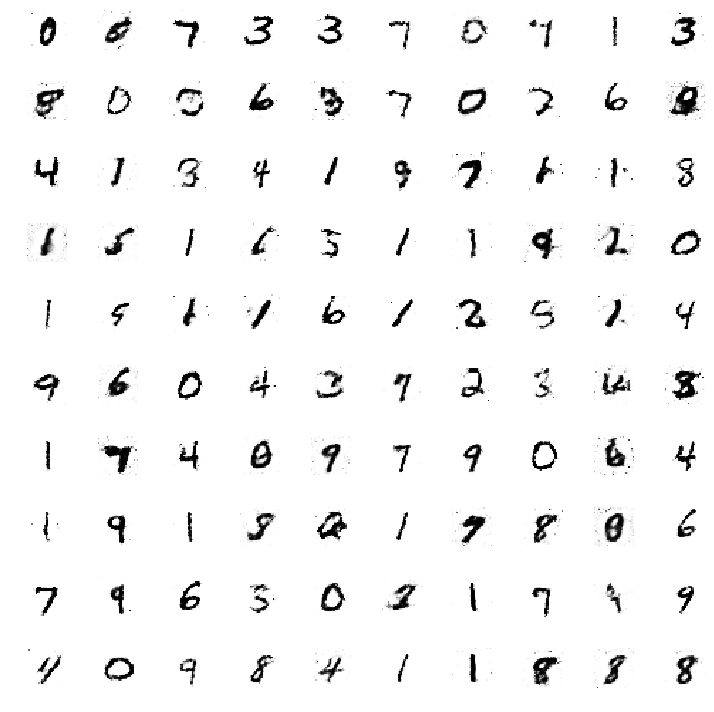

--------------- Epoch 61 ---------------
--------------- Epoch 62 ---------------
--------------- Epoch 63 ---------------
--------------- Epoch 64 ---------------
--------------- Epoch 65 ---------------
--------------- Epoch 66 ---------------
--------------- Epoch 67 ---------------
--------------- Epoch 68 ---------------
--------------- Epoch 69 ---------------
--------------- Epoch 70 ---------------
--------------- Epoch 71 ---------------
--------------- Epoch 72 ---------------
--------------- Epoch 73 ---------------
--------------- Epoch 74 ---------------
--------------- Epoch 75 ---------------
--------------- Epoch 76 ---------------
--------------- Epoch 77 ---------------
--------------- Epoch 78 ---------------
--------------- Epoch 79 ---------------
--------------- Epoch 80 ---------------


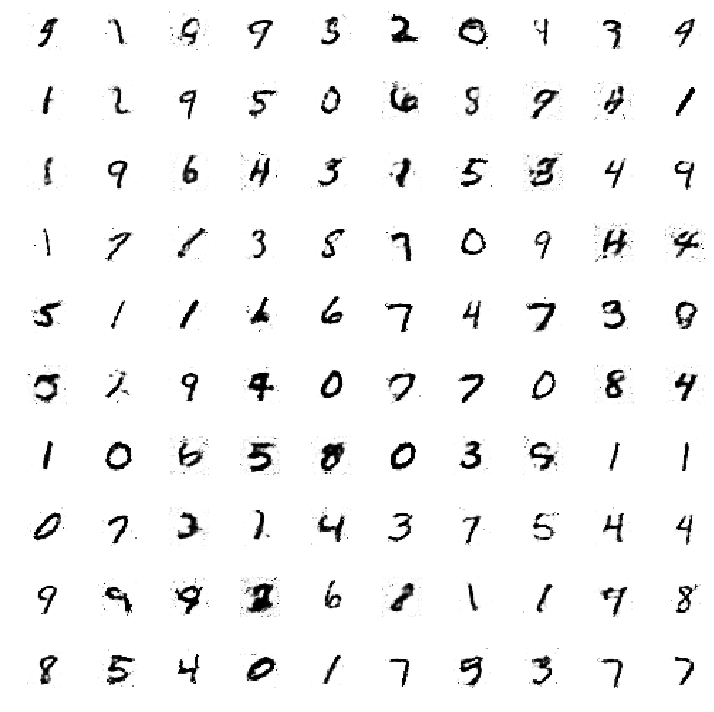

--------------- Epoch 81 ---------------
--------------- Epoch 82 ---------------
--------------- Epoch 83 ---------------
--------------- Epoch 84 ---------------
--------------- Epoch 85 ---------------
--------------- Epoch 86 ---------------
--------------- Epoch 87 ---------------
--------------- Epoch 88 ---------------
--------------- Epoch 89 ---------------
--------------- Epoch 90 ---------------
--------------- Epoch 91 ---------------
--------------- Epoch 92 ---------------
--------------- Epoch 93 ---------------
--------------- Epoch 94 ---------------
--------------- Epoch 95 ---------------
--------------- Epoch 96 ---------------
--------------- Epoch 97 ---------------
--------------- Epoch 98 ---------------
--------------- Epoch 99 ---------------
--------------- Epoch 100 ---------------


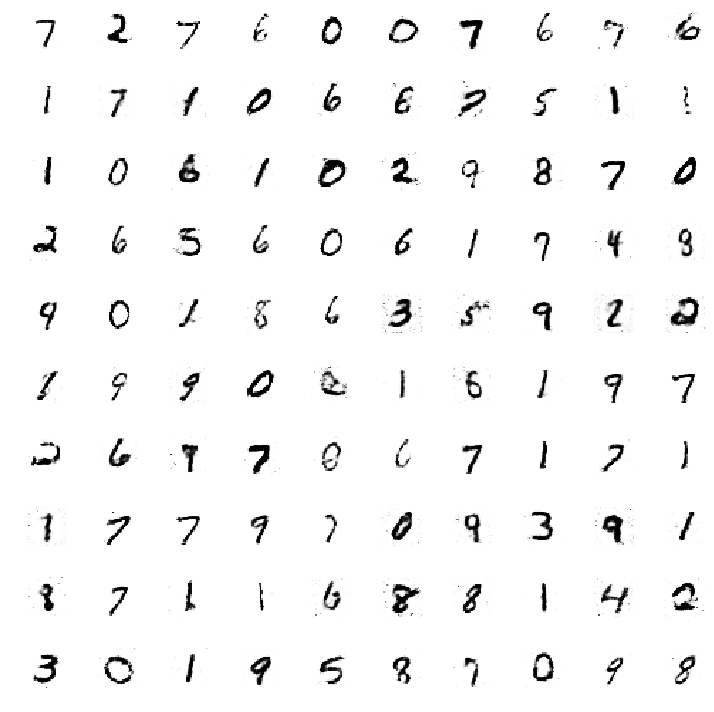

Saved model to disk


In [11]:
# Training for E epochs
train(100, 128)

In [12]:
# load json and create model
json_file = open('generator.json', 'r')
loaded_gen_json = json_file.read()
json_file.close()
generator = model_from_json(loaded_gen_json)
# load weights into new model
generator.load_weights("generator.h5")
print("Loaded generator model from disk")

# load json and create model
json_file = open('discriminator.json', 'r')
loaded_disc_json = json_file.read()
json_file.close()
discriminator = model_from_json(loaded_disc_json)
# load weights into new model
discriminator.load_weights("discriminator.h5")
print("Loaded discriminator model from disk")

Loaded generator model from disk
Loaded discriminator model from disk


In [78]:
# Discriminator prediction accuracy on a batch of the MNIST test set
batch_size = 128
noise = np.random.normal(0, 1, size=[batch_size, random_dim])

_, _, x_test, y_test = load_mnist_data()

test_real_batch = x_test[np.random.randint(0, x_test.shape[0], size=batch_size)]
test_real_batch = test_real_batch.reshape(batch_size, 784)
test_gen_batch = generator.predict(noise)

In [79]:
x_test_batch = np.concatenate([test_real_batch, test_gen_batch])
y_test_batch = np.concatenate([np.ones(test_real_batch.shape[0]), np.zeros(test_gen_batch.shape[0])])
y_test_batch = y_test_batch.reshape((256,1))

predictions = discriminator.predict(x_test_batch)
rounded_pred = np.round(predictions)
# accuracy = np.sum(y_test_batch == predictions) /
# print("Accuracy of the discriminator after 100 epochs: ", accuracy)

In [95]:
accuracy = np.sum(y_test_batch == rounded_pred) / (2 * batch_size)
print("Accuracy of the discriminator after 100 epochs: ", accuracy)

Accuracy of the discriminator after 100 epochs:  0.4609375


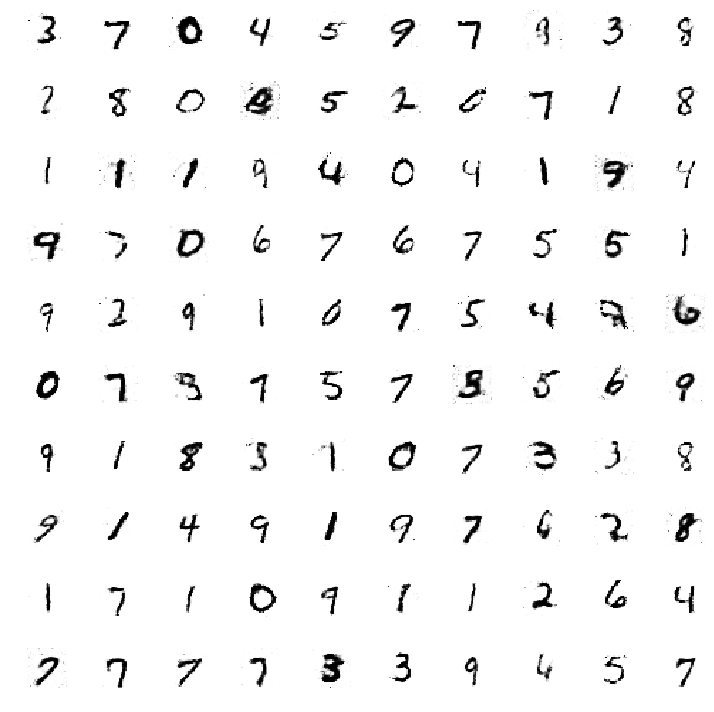

In [25]:
plot_generated_images(100, generator)